
This is programming assignment for week 1. In this assignment you will be working with scikit-learn to perform exploratory data analysis and practice working with text data. 

Please, read all the notebook carefully and make sure that you understand not only the task, but the whole pipeline.

### Grading
The assignment is automatically graded. 

**Automatic grading**
After you finish solving all the tasks restart the kernel (`kernel -> restart`) and click the button `Validate` to check that everything works as expected. Afterwards, you can submit your work.

**Please delete raise NotImplementedError() after writing Python statements in a code cell**


# Table of Contents:
* [Problem 1.](#part1)  Exploratory data analysis
     - [Task 1](#task1) [1 pt]
     - [Task 2](#task2) [2 pts]
     - [Task 3](#task3) [2 pts]
     - [Task 4](#task4) [1 pt]
     - [Task 5](#task5) [1 pts]
     - [Task 6](#task6) [2 pts]
     - [Task 7](#task7) [1 pts]
   
* [Problem 2](#problem2). Text data analysis
    - [Task 1](#task2_1) [2 pts]
    - [Task 2](#task2_2) [1 pts]
    - [Task 3](#task2_3) [1 pts]
    - [Task 4](#task2_4) [1 pts]


---
## Problem 1. Exploratory data analysis <a class="anchor" id="part1"></a>
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import  KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

In this task we will go through standard exploratory data analysis and preprocessing steps as well as use them to prepare a dataset and train a predictive model.

Let's take a look at the data. We will analyze a dataset of diamond characterics, such as size, color and clarity, in order to train a model to predict it's price.

<!-- The data used in this task is slighly preprocessed open dataset from kaggle.com https://www.kaggle.com/shivam2503/diamonds  -->

First, we need to exclude the target variable, `price`, and split the dataset into train and test sets. We will use the former to perform all the data analysis steps and train the model, and the latter - to assess the model prediction quality on new data.

In [3]:
file_path = "https://github.com/mbburova/MDS/raw/main/diamonds_prep.csv"
df = pd.read_csv(file_path, index_col=0)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,NaN,NaN,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,NaN,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
y = df["price"]
X = df.drop("price", axis=1)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=1)

This dataset contains both numerical and categorical characteristics. The latter ones take string values, each of which means a certain category. Most standard machine learning algorithms are able to work only with numerical variables, and categorical data have to be additionally prepared before model training. 

<!-- Also, most of the models usually cannot handle missing values in the data, so we need to check if there are any in our dataset. -->

<!-- However, first we will need to check if there are any **missing values** in the data and properly handle them.  -->

In [5]:
print("Types of variables presented in the training data:\n")
X_tr.dtypes

Types of variables presented in the training data:



carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
dtype: object

Number of numerical features = 6 

Distribution of numerical features:


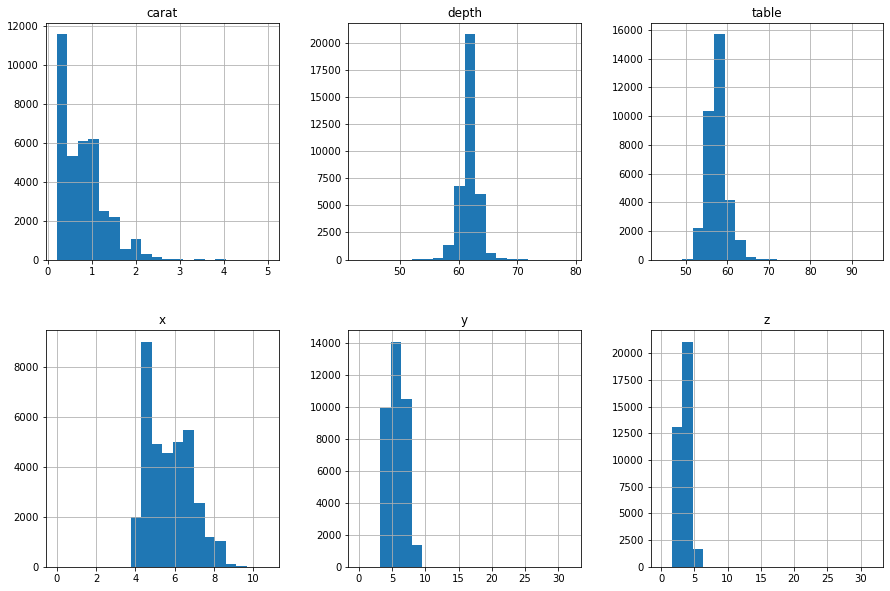

In [6]:
num_cols = X_tr.columns[(X_tr.dtypes == "int64") |
(X_tr.dtypes == "float64")].tolist() #
print("Number of numerical features =", len(num_cols), "\n")

print("Distribution of numerical features:")
X_tr[num_cols].hist(bins=20, grid=True, figsize=(15, 10), layout=(2, 3))
plt.show()

In [8]:
print("Number of missing values in each column:\n")
X_tr[num_cols].isnull().sum()

Number of missing values in each column:



carat    1915
depth    1913
table    3784
x        1854
y        1875
z        1885
dtype: int64

Number of categorical features = 3 

Distribution of categorical features:


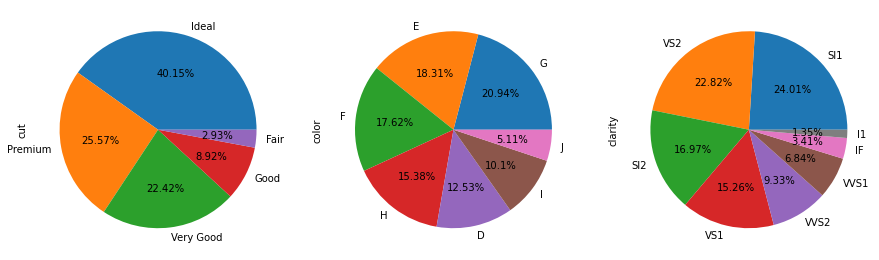

In [9]:
cat_cols = X_tr.columns[X_tr.dtypes == "object"].tolist() #
print("Number of categorical features =", len(cat_cols), "\n")

print("Distribution of categorical features:")
plt.figure(figsize=(15, 5))
for i, col in enumerate(cat_cols):
    plt.subplot(1, 3, i + 1)
    X_tr[col].value_counts(normalize=True).plot.pie(autopct=lambda x: f"{round(x, 2)}%")
plt.show()

In [10]:
print("Number of missing values in each column:\n")
X_tr[cat_cols].isnull().sum() 

Number of missing values in each column:



cut        1912
color      3724
clarity    1793
dtype: int64

### Missing values

<!-- [Missing values recap] - missing values may occir / appear in the data for various reasons. -->

Most of the classical models are unable to handle missing values. Thus, we need to remove them from the data or fill with some value.

There exist various strategies to deal with missing values. If some column or row lacks a significant part of the data, it may be reasonable to completely drop it. However, in most cases, this leads to significant information loss. Instead, missing values can be filled with some constant (such as 0 or an empty string), or a statistic of the corresponding feature (such as mean, median, or mode). When filling missing values, one may also create an additional feature that indicates whether the value was present in the original data. This can be informative because sometimes the absence of a feature value can be a feature in itself.


<!-- Однако в большинстве случаев это приводит к значительной потере информации. Вместо этого, пропущенные значения могут быть заполнены некоторой константой, например нулем или пустой строкой, или статистикой по соответствующему признаку (например, средним, медианой или модой). При заполнении пропущенных значений, может быть также полезно создавать дополнительный признак-индикатор, указывающий, имелось ли это значение в изначальных данных. Так как иногда отсутствие значения само по себе может являться признаком. -->

<!-- - (the most simple) just remove the feature that contains missing values and / or objects that have many empty fiels,
- fill missing values with some constant value, for example, 0, -1 or an empty string
- fill missing values with some statistic of the feature (mean, median, mode, etc)
- ... -->


---
**Task 1.1** [1 pt]  <a class="anchor" id="task1"></a>

Write a function that removes objects from the dataset, if they have more than **50%** of missing values.
- Use pandas `isnull()` method to find missing (NaN) values. See example above.
- Compute number of missing values in each row. Use argument `axis` to specify the dimention of summation. 
- From both the object matrix `X` and the target variable `y`, select a subset of rows with **at most 50%** of missing values.
- See [this pandas tutorial](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#boolean-indexing) if you struggle to implement this task.

In [50]:
def drop_uninformative_objects(X, y):
    # YOUR CODE HERE
    X_subset = X[~(X.isnull().sum(axis=1)/X.shape[1] > 0.5)]
    y_subset = y[X_subset.index]
    return X_subset, y_subset

In [51]:
# TEST drop_uninformative_objects function
A = pd.DataFrame(np.array([
    [0, 3, np.nan],
    [4, np.nan, np.nan],
    [np.nan, 6, 7],
    [np.nan, np.nan, np.nan],
    [5, 5, 5],
    [np.nan, 8, np.nan],
]))
b = pd.Series(np.arange(6))
A_subset, b_subset = drop_uninformative_objects(A, b)

Now, we can use this function to drop rows with too many missing values from the training dataset. 

In [52]:
X_tr, y_tr = drop_uninformative_objects(X_tr, y_tr)

For categorical features, let's basically fill missing values with a constant value - an "Unknown" string.

In [53]:
X_tr[cat_cols] = X_tr[cat_cols].fillna("Unknown")
X_te[cat_cols] = X_te[cat_cols].fillna("Unknown")


---
**Task 1.2** [2 pts]  <a class="anchor" id="task2"></a>

For numerical features, impelement a class that fills missing values in each feature with its mean value.

- Implement a `fit` method that takes as input feature matrix `X` and computes and saves **mean** value of each feature (assuming that all the features are numerical). The feature matrix can be either `pd.DataFrame`, or `np.ndarray`.
- Implement a `transform` method that takes as input feature matrix `X` and replaces NaN values in each feature with a corresponding mean value and returns a transformed feature matrix. 

<!-- Note, that `fit` method also takes target variable `y` as argument. It is needed for compatibility with other ML staff, however, in this class target variable will not be used, and you can just leave it equal to `None`. -->


In [81]:
from sklearn.base import TransformerMixin, BaseEstimator

class MeanImputer(BaseEstimator, TransformerMixin): 
    def fit(self, X, y=None):
        """
        Compute and save mean value of each feature in the feature matrix.

        Parameters
        ----------
        X : pd.DataFrame or numpy.ndarray of shape (n_samples, n_features)
            Feature matrix.
        y : pd.Series or numpy.ndarray of shape (n_samples,) (default : None)
            Target values. Optional.
        
        Returns
        -------
        self : returns an instance of self.
        """
        self.column_mean = []
        for i in range(X.shape[1]):
            if type(X) is not np.ndarray:
                X_i = X.values[:, i]
            else:
                X_i = X[:, i]
                
            # calculate mean for each column and add to the list `self.column_mean`
            # YOUR CODE HERE
            self.column_mean.append(np.nanmean(X_i))
        return self
    
    def transform(self, X):
        """
        Fills missing values in each feature with a corresponding mean value.

        Parameters
        ----------
        X : pd.DataFrame or numpy.ndarray of shape (n_samples, n_features)
            Feature matrix.
        
        Returns
        -------
        X_transformed : array-like of shape (n_samples, n_features)
            Transformed feature matrix. 
        """

        X_transformed = []
        for i in range(len(self.column_mean)):
            if type(X) is not np.ndarray:
                X_i = X.values[:, i]
            else:
                X_i = X[:, i]
                
            # Fill missing values using mean values 
            # YOUR CODE HERE
            X_transformed.append(np.nan_to_num(X_i, nan=self.column_mean[i]))
        
        X_transformed = np.column_stack(X_transformed)
        return X_transformed

In [68]:
# TEST MeanImputer class
A = np.array([
    [0, np.nan, 3],
    [np.nan, 6, 7],
    [np.nan, 8, np.nan],
])
mean_imp = MeanImputer()
mean_imp.fit(A)
print(mean_imp.column_mean)

[0.0, 7.0, 5.0]


### Numerical features

From the histograms of numerical variables, you can also see that different features have different value ranges. However, many machine learning models, in particular linear models and kNN algorithm, are sensitive to feature scales. Therefore, it is a good practice to scale all the numeric variables to the same range before training.




---
**Task 1.3** [2 pts]  <a class="anchor" id="task3"></a>

For numerical features, impelement a class that normalizes each feature values by subtracting the mean and dividing by the standard deviation.

- Implement a `fit` method that takes as input feature matrix `X` and computes and saves **mean** and **std** values of each feature (assuming that all the features are numerical). The feature matrix can be either `pd.DataFrame`, or `np.ndarray`.
- Implement a `transform` method that takes as input feature matrix `X` and normalizes each column using precomputed mean and std values for this feature. 

In [72]:
from sklearn.base import TransformerMixin, BaseEstimator

class Scaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        """
        Compute and save mean and standard deviation values 
        of each feature in the feature matrix.

        Parameters
        ----------
        X : pd.DataFrame or numpy.ndarray of shape (n_samples, n_features)
            Feature matrix.
        y : pd.Series or numpy.ndarray of shape (n_samples,) (default : None)
            Target values. Optional.
        
        Returns
        -------
        self : returns an instance of self.
        """
        self.column_mean = []
        self.column_std = []
        for i in range(X.shape[1]):
            # extract column values 
            if type(X) is not np.ndarray:
                X_i = X.values[:, i]
            else:
                X_i = X[:, i]
                
            # compute mean and std
            # YOUR CODE HERE
            self.column_mean.append(np.nanmean(X_i))
            self.column_std.append(np.nanstd(X_i))
        return self
    
    def transform(self, X):
        """
        Normalizes values of each feature 
        by subtructing the corresponding precomputed feature mean 
        and dividing by the corresponding standard deviation.

        Parameters
        ----------
        X : pd.DataFrame or numpy.ndarray of shape (n_samples, n_features)
            Feature matrix.
        
        Returns
        -------
        X_transformed : array-like of shape (n_samples, n_features)
            Transformed feature matrix. 
        """   
        X_transformed = []
        
        for i in range(len(self.column_mean)):
            # extract column values 
            if type(X) is not np.ndarray:
                X_i = X.values[:, i]
            else:
                X_i = X[:, i]
                
            # YOUR CODE HERE
            X_transformed.append((X_i - self.column_mean[i])/ self.column_std[i])
            
        X_transformed = np.column_stack(X_transformed)
        return X_transformed

In [73]:
# TEST Scaler class
A = np.arange(9).reshape(3, 3)
scaler = Scaler()
scaler.fit(A)


Scaler()

 ### Model training and validation

Now, we will train and evaluate the first regression model for diamond price prediction using only the numerical features. We will use **k-nearest neighbors** algorithm to build the model, and mean absolute error metric to evaluate its predictive performance. 

It is important that for correct and fair training, the test set should not be used at any stage of model building. Therefore, statistics for feature preprocessing have to be estimated only on the training sample. For example, the mean and standard deviation of each column should be computed on the training set and then used to normalize the features in both the training and test sets.

`Sklearn` contains ready-to-use feature transformer classes, with the `fit` method to estimate parameters on the training set and the `transform` method to actually apply the transformation to training and test sets. `MeanImputer` and `Scaler` classes, that you have implemented previously, are also compatible with other sklearn transformers.

There also exist several tools to combine transformers and estimators into a single pipeline:
- `ColumnTransformer`
- `Pipeline`
- `make_pipeline`

In [82]:
# define transformations for numerical columns using MeanImputer and Scaler
num_transformers_pipe = make_pipeline(
    MeanImputer(),
    Scaler(),
)

# defien column transformer (we drop non-numerical features)
col_transformer = ColumnTransformer([
    ("num_col_transformer", num_transformers_pipe, num_cols),
], remainder='drop')


# define a Pipeline with 2 steps: 1. transform columns; 2. Apply the model
model = Pipeline([
    ("col_transformer", col_transformer),
    ("estimator", KNeighborsRegressor())
]
)


---
**Task 1.4** [1 pt]  <a class="anchor" id="task4"></a>

Implement a function to evaluate performance of a given model both on the train and test sets. The function should
- take as input a model (possibly a pipeline), as well as feature matrix and target variable for both train and test sets,
- fit the model on the train set,
- compute model predictions for train and test sets,
- assess the quality of both predictions with mean absolute error (MAE) metric,
- return train and test MAE scores.

In [87]:
def evaluate_model(model, X_tr, y_tr, X_te, y_te):
    # YOUR CODE HERE
    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_tr)
    mae_tr = mean_absolute_error(y_tr, y_hat)

    y_hat = model.predict(X_te)
    mae_te = mean_absolute_error(y_te, y_hat)

    return mae_tr, mae_te

Evaluate performance of the model based on numerical features only:

In [88]:
# TEST evaluate_model function
mae_tr, mae_te = evaluate_model(model, X_tr, y_tr, X_te, y_te)


In [89]:
models_scores = {}
models_scores["num only"] = {"train" : mae_tr, "test" : mae_te}
print("Train MAE = %.2f" % mae_tr)
print("Test MAE = %.2f" % mae_te)

Train MAE = 684.53
Test MAE = 833.04


### Categorical features

<!-- [categorical features recap?] -->

Most of the machine learning models cannot work with categorical features directly in their original form. However, there are several ways to represent them in an alternative form (encode). We will consider and compare two options for encoding categorical features - **one-hot encoding** and **mean target encoding**.

Ohe-hot-encoding is one of the most popular and straight-forward ways. In this case each categorical feature is replaced by a set of binary features for each category. 

`Sklearn` has ready-to-use implementation of OneHotEncoder transformer (as well as many other transformers). 



In [ ]:
print("Categorical variable before one-hot encoding:")
display(X_tr[["cut"]].head())

print("Categorical variable after one-hot encoding:")
ohenc = OneHotEncoder(sparse=False)
ohenc.fit_transform(X_tr[["cut"]])
display(pd.DataFrame(ohenc.fit_transform(X_tr[["cut"]]), 
                     index=X_tr.index, columns=ohenc.categories_).head())

**Task 1.5** [1 pts]  <a class="anchor" id="task5"></a>

Let us create a 2-step pipeline:

1. Column Transformer, which
    - Apply one-hot encoding to categorical feature
    - Apply `num_transformers_pipe` (defined above) to numerical feature
2. A regression model

Please, finish the definition of the `col_transformer`.

In [121]:

col_transformer = ColumnTransformer([
    # YOUR CODE HERE
    ('ohe', OneHotEncoder(), X_tr.columns[X_tr.dtypes == 'object'].to_list()),
    ('scaling', num_transformers_pipe, X_tr.columns[X_tr.dtypes == 'float64'].to_list()),
], remainder='drop')

model = Pipeline(steps = [
    ("col_transformer", col_transformer),
    ("estimator", KNeighborsRegressor())
])

In [122]:

mae_tr, mae_te = evaluate_model(model, X_tr, y_tr, X_te, y_te)
models_scores["num & cat (one-hot)"] = {"train" : mae_tr, "test" : mae_te}
print("Train MAE = %.2f" % mae_tr)
print("Test MAE = %.2f" % mae_te)

Train MAE = 428.27
Test MAE = 526.21


### Mean target encoding

Another way to encode categorical variables in **mean target encoding**. The idea behind the approach is that each of the categories is replaced by the average value of the target variable for objects from that category. Thus, the categorical feature can be encoded with a single numerical vector.

<!-- [overfirtting and adding noise to the target variable] -->


---
**Task 1.6** [2 pts]  <a class="anchor" id="task6"></a>

Implement mean target encoding transformer. 

In [151]:
from sklearn.base import TransformerMixin, BaseEstimator

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    """
    Encode categorical features as a numerical vector 
    of mean target values for each category.

    Parameters
    ----------
    noise_level : float, default=0.01
        The variance of Gaussian noise to be added to the target variable 
        before computing the mean. Larger values lead to less accurate 
        mean values for categories but prevent overfitting.
    """

    def __init__(self, 
                 noise_level=0.01):
        self.noise_level = noise_level
    
    def fit(self, X, y):
        """"
        For each feature in the feature matrix, 
        compute and save mean target value for each category. 
        
        All the values are stored in the dictionary `self.column_category_mean`
        Keys - column names. Values - dictionary with unique categories and corresponding means
        
        Example for 2 categorical features: `district`, `city_type`  
        self.column_category_mean = {
                                    'distric': {'central': 2000, 
                                                 'south': 1000, 
                                                 'north': 1500},
                                    'city_type': {'capital': 2100,
                                                  'small city': 1700,
                                                  'village': 1200}
                                      }

        Parameters
        ----------
        X : pd.DataFrame or numpy.ndarray of shape (n_samples, n_features)
            Feature matrix.
        y : pd.Series or numpy.ndarray of shape (n_samples,) (default : None)
            Target values.
        Returns
        -------
        self : returns an instance of self.
        """
        
        # get target and add noise to it
        if type(y) is not np.ndarray:
            target = y.values.copy()
        else:
            target = y.copy()
        if self.noise_level > 0:
            noise = np.random.randn(target.size) * (self.noise_level * target.std())
            target = target + noise


        self.column_category_mean = {}
        
        for i in range(X.shape[1]):
            # get column name (`col`) and the values (`X_i`)
            if type(X) is not np.ndarray:
                col = X.columns[i]
                X_i = X[col].values
            else:
                col = i
                X_i = X[:, col]
                
            # YOUR CODE HERE
            df = pd.DataFrame({
                'col': X_i, 
                'target': y,
            })
            
            self.column_category_mean[col] = df.groupby('col').mean().to_dict()
    
        return self
    
    def transform(self, X):
        """
        For each feature in the feature matrix,
        replaces each category with a corresponding precomuted 
        mean target value.

        Parameters
        ----------
        X : pd.DataFrame or numpy.ndarray of shape (n_samples, n_features)
            Feature matrix.
        
        Returns
        -------
        X_transformed : array-like of shape (n_samples, n_features)
            Transformed feature matrix. 
        """
        print(self.column_category_mean)

        X_transformed = []
        for col in self.column_category_mean:
            # extract column values 
            if type(X) is not np.ndarray:
                X_i = X[col].values
            else:
                X_i = X[:, col]
                
            # encode categories of X_i using `self.column_category_mean`. And append the result to `X_transformed`
            # YOUR CODE HERE
            feature = self.column_category_mean[col]
            print(col)
            print(X_i)
            print(feature)
            for v in X_i:
                print(v)
                X_transformed.append(feature[v])
                
        X_transformed = np.column_stack(X_transformed)
        return X_transformed

In [152]:
# TEST MeanTargetEncoder

# toy dataset
dist = ['south', 'central', 'south','central','north','north','central']
city = ['small city', 'small city', 'capital', 'village', 'capital', 'capital', 'village']
price = np.array([1000, 2000, 3000, 2800, 1200, 1700, 2100])
X = pd.DataFrame({'district':dist, 'city_type': city})

# mean target encoder
enc = MeanTargetEncoder(noise_level=0.)
enc.fit(X, price)
X_encoded = pd.DataFrame(enc.transform(X), columns = X.columns)
display(X_encoded)

       col  target
0    south    1000
1  central    2000
2    south    3000
3  central    2800
4    north    1200
5    north    1700
6  central    2100
          col  target
0  small city    1000
1  small city    2000
2     capital    3000
3     village    2800
4     capital    1200
5     capital    1700
6     village    2100
{'district': {'target': {'central': 2300.0, 'north': 1450.0, 'south': 2000.0}}, 'city_type': {'target': {'capital': 1966.6666666666667, 'small city': 1500.0, 'village': 2450.0}}}
district
['south' 'central' 'south' 'central' 'north' 'north' 'central']
{'target': {'central': 2300.0, 'north': 1450.0, 'south': 2000.0}}
south


KeyError: 'south'

In [ ]:
# use Mean Target encoder instead of OHE
cat_mean_target_enc = make_pipeline(
    MeanTargetEncoder(noise_level=0.01),
    StandardScaler(),
)

col_transformer = ColumnTransformer([
    ("num_col_transformer", num_transformers_pipe, num_cols),
    ("cat_mean_target", cat_mean_target_enc, cat_cols),
], remainder='drop')


model = Pipeline([
    ("col_transformer", col_transformer),
    ("estimator", KNeighborsRegressor())
])

In [ ]:
mae_tr, mae_te = evaluate_model(model, X_tr, y_tr, X_te, y_te)
models_scores["num & cat (mean target)"] = {"train" : mae_tr, "test" : mae_te}
print("Train MAE = %.2f" % mae_tr)
print("Test MAE = %.2f" % mae_te)


### Ordinal categorical variables

In some cases, categorical variables may have ordinal values. For example, in our data, the attribute "cut" has values Fair, Good, Very Good, Premium, and Ideal. We can assume that these values are "ordered" and encode them with the numbers 1, 2, 3, 4 and 5 respectively. Thus, 1 means "worst" value (Fair) and 5 means "best" (Ideal) and 0 can be used to encode "Unknown" (missing) values. 
This can provide additional information to the model and improve quality, especially for linear models.



In [ ]:
# separate columns with ordinal features from other categorical features
ord_cols = ["cut"]
cat_cols = list(set(cat_cols) - set(ord_cols))
print(cat_cols, ord_cols)

In [ ]:
# create lists of categories for each ordinal feature
# (categories should be ordered from minimal to maximal)
ord_col_categories = [[
    "Unknown",
    "Fair",
    "Good",
    "Very Good",
    "Premium",
    "Ideal",          
]]

In [ ]:
# defien ordinal encoder
ord_enc = make_pipeline(
    OrdinalEncoder(categories=ord_col_categories),
    StandardScaler(),
)

# combine all column transforms
col_transformer = ColumnTransformer(transformers = [
    ("num_col_transformer", num_transformers_pipe, num_cols),
    ("cat_one_hot",  OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("ord_enc", ord_enc, ord_cols)
], remainder='drop')


model = Pipeline(steps = [
    ("col_transformer", col_transformer),
    ("estimator", KNeighborsRegressor())
])

In [ ]:
# evaluate model performance
mae_tr, mae_te = evaluate_model(model, X_tr, y_tr, X_te, y_te)
models_scores["num, cat & ord"] = {"train" : mae_tr, "test" : mae_te}
print("Train MAE = %.2f" % mae_tr)
print("Test MAE = %.2f" % mae_te)


### Feature engineering

We can also use the original features to derive new, more complex or informative features on their basis. 

For example, in our data we have three features "x", "y" and "z" and can assume that they correspond to measurements of the diamond size along three axes. In this case, product of these three features, that is, the approximate volume, can also be a useful feature for predicting the value of a diamond.



In [ ]:
X_tr.head()

---
**Task 1.7** [1 pts]  <a class="anchor" id="task7"></a>

Add `volume` feature as a product of `x`, `y`, `z` features (to both train and test datasets)

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print("Distribution of created features:")
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
X_tr[["volume"]].hist(bins=20, grid=True, ax=ax[0])
ax[0].set_title('Volume on train')
X_te[["volume"]].hist(bins=20, grid=True, ax=ax[1]);
ax[0].set_title('Volume on test')


In [ ]:
# update list of numerical features
num_cols = X_tr.columns[np.logical_or(X_tr.dtypes == "int64", X_tr.dtypes == "float64")].tolist() #
num_cols

In [ ]:
# define columns transforms (nothing cahnges for ordinal and categorical features, but the list of numerical features was updated)
col_transformer = ColumnTransformer(transformers = [
    ("num_col_transformer", num_transformers_pipe, num_cols),
    ("cat_one_hot", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("ord_enc", ord_enc, ord_cols)
], remainder='drop')

model = Pipeline(steps = [
    ("col_transformer", col_transformer),
    ("estimator", KNeighborsRegressor())
])

In [ ]:
# evaluate model performance
mae_tr, mae_te = evaluate_model(model, X_tr, y_tr, X_te, y_te)
models_scores["num, cat & ord + engineering"] = {"train" : mae_tr, "test" : mae_te}
print("Train MAE = %.2f" % mae_tr)
print("Test MAE = %.2f" % mae_te)

Finally, we may look how model performance on train and test sets have changed depending on the used features.

In [ ]:
models = list(models_scores.keys())
train_scores = [models_scores[model]["train"] for model in models]
test_scores = [models_scores[model]["test"] for model in models]

plt.figure(figsize=(10, 5))
plt.plot(train_scores)
plt.plot(test_scores)
plt.scatter(range(len(models)), train_scores, label="train")
plt.scatter(range(len(models)), test_scores, label="test")
plt.xticks(range(len(models)), models, rotation=30)
plt.xlabel("Features used", fontdict={"size" : 12})
plt.ylabel("Model's MAE score", fontdict={"size" : 12})
plt.title("Dependence of model's score on the features used", fontdict={"size" : 14})
plt.legend()
plt.grid()
plt.show()

---
## Problem 2. Text data analysis <a class="anchor" id="problem2"></a>
---

In [ ]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

---

In this part, we will solve the problem of prediction price of the wine based on text description of its characteristics. When working with text features, you have to first transform them into a vector form (vectorize) so that the model can process them. We wil consider two vectorization methods, 
* **Bag-of-Words** 
* **Tf-Idf**.

Let us read the data:

In [ ]:
df = pd.read_csv("https://github.com/mbburova/MDS/raw/main/winemag-data_first50k.csv", index_col=0)
# drop rows with unknown price
df = df.loc[df["price"].notnull()]

y = df["price"]
X = df.drop(["price"], axis=1)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=1)

### Bag-of-Words vectorization

Bag-of-Words is one of the most obvious and straight-forward for the text descriptions vectorization.
In this case, we just create a feature column for each word appearing in the texts of the dataset. If the particular word is presented in the text description of a particular object, the value of the corresponding feature will be equal to 1, else - equal to 0. It is also possible to set the value of the feature to the number of times that the corresponding word has appeared in the object description.

In `sklearn`, you can obtain bag-of-words vector representation of the text using the `CountVectorizer` transformer. Note, that in this case value of the resulting features will be equal to the number of times the corresponding word appeared in the object description text.

---
**Task 2.1** [2 pts]  <a class="anchor" id="task2_1"></a>

Before vectorization, we need to prepare text descriptions. Write a function to clear the text from all non-alphabetic characters and convert it to lowercase. 

**Hint**
- `.lower()` method is used to conver any string to the lower case. E.g `'Hello'.lower()` retuns `'hello'`
- Use `re.sub()` to replace all non-alphabetic characteer with empty string. You cen read more about it in the [documentation](https://docs.python.org/3/library/re.html)


In [ ]:
import re
def prepare_text(text):
    """
    Converts the text to lowercase and removes all the non-alphabetic characters
    (the cleared text should contain only letters from a to z and space symbols).
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    return cleared_text

In [ ]:
### TEST prepare_text
processed = prepare_text('CLEAR it!!!')
assert 'clear it' == processed


---
**Task 2.2** [1 pt]  <a class="anchor" id="task2_2"></a>

Apply `prepare_text` function to the `description` feature column in the datasets `X_tr` and `X_te`. 

**Hint** Use the method `apply`from [pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html)

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# make sure that this string does not contain upper case letter and non-alphabetical characters
print(X_tr["description"][0])


---
**Task 2.3** [1 pt]  <a class="anchor" id="task2_3"></a>

Perform the **Bag-of-Words vectorization** of the texts in `description` column, train the linear regression model on the obtained numerical features and evaluate its mean absolute error on the test set.

- Use `CountVectorizer` from sklearn to perform Bag-of-Words vectorization. 
    - Use the argument `min_df=0.001` to remove the words which appear in less then 0.1% of the documents
    - Read more about it the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
- Fit the vectorizer using descriptions from the train dataset
- Create `textfeats_tr` which contains transformed descriptions from the train dataset
- Create `textfeats_te` which contains transformed descriptions from the test dataset

In [ ]:
bow_vectorizer = CountVectorizer(min_df=0.001)
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
### TEST bag-of-words vectorization
print(textfeats_tr.shape)
print(textfeats_te.shape)



Train and evaluate a `LinearRegression` model on the obtained features. We will use function `evaluate_model`, that you've created in the previous part.

In [ ]:
model = LinearRegression()
mae_tr, mae_te = evaluate_model(model, textfeats_tr, y_tr, 
                                textfeats_te, y_te)
print("Train MAE = %.3f" % mae_tr)
print("Test MAE = %.3f" % mae_te)

### Tf-Idf vectorization

Another way to deal with text data is TF-IDF - Term Frequency - Inverse Document Frequency vectorization. 

---
**Task 2.4** [1 pts]  <a class="anchor" id="task2_4"></a>

Perform **Tf-Idf vectorization** of the cleaned description obtained in the previous step. 


- Use `TfidfVectorizer` from sklearn to perform Bag-of-Words vectorization. 
    - Use the argument `min_df=0.001` to remove the words which appear in less then 0.1% of the documents
    - Read more about it the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- Fit the vectorizer using descriptions from the train dataset
- Create `textfeats_tr` which contains transformed descriptions from the train dataset
- Create `textfeats_te` which contains transformed descriptions from the test dataset

In [ ]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.001)
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
### TEST bag-of-words vectorization
print(textfeats_tr.shape)
print(textfeats_te.shape)



Again, we need to train and evaluate the linear regression model on the vectorized text features.

In [ ]:
model = LinearRegression()
mae_tr, mae_te = evaluate_model(model, textfeats_tr, y_tr, 
                                textfeats_te, y_te)
print("Train MAE = %.3f" % mae_tr)
print("Test MAE = %.3f" % mae_te)